##### Simple Model Chat

In [1]:
## Simple Model Chat
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable
groq_api_key=os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
model=ChatGroq(model="Gemma2-9b-It",groq_api_key=groq_api_key)
response=model.invoke([HumanMessage(content="Hi , My name is DP Sharma and I am a Chief AI Engineer")]) 
print(response.content)

Hello DP Sharma, it's nice to meet you!

As a Chief AI Engineer, I imagine you have a lot of fascinating work to do.  What are some of the most exciting projects you're currently involved in? 

I'm always eager to learn more about how AI is being used to make a difference in the world.



##### Multiple Message Chat
- In this section, we will cover the basics of chatbots, including how to design and implement an LLM-powered chatbot. This chatbot will be capable of holding conversations and remembering previous interactions.
- Note that the chatbot we build will rely solely on the language model for conversation.

In [2]:
## Multiple MMessage Chat
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable
groq_api_key=os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,AIMessage
model=ChatGroq(model="Gemma2-9b-It",groq_api_key=groq_api_key)
response=model.invoke(
    [
        HumanMessage(content="Hi, My name is DP Sharma and I am a Chief AI Engineer"),
        AIMessage(content="Hello DP Sharma, it's a pleasure to meet you!\n\nAs a Chief AI Engineer, I imagine you have a lot of exciting projects on your plate. What kind of work are you currently focusing on?\n\nI'm always interested in learning more about the cutting-edge applications of AI. Perhaps you could tell me about:\n\n* **The most challenging AI problem you're trying to solve.**\n* **A recent success you're particularly proud of.**\n* **Your vision for the future of AI in your field.** \n\n\nI'm eager to hear your insights!\n"),
        HumanMessage(content="Hey, what's my name and what do I do?")
    ]
) 
print(response.content)

You are DP Sharma, and you are a Chief AI Engineer. 

Is there anything else I can help you with?  Perhaps you'd like to discuss some AI projects or explore the latest advancements in the field? 😊  



##### Sessions based chat history 

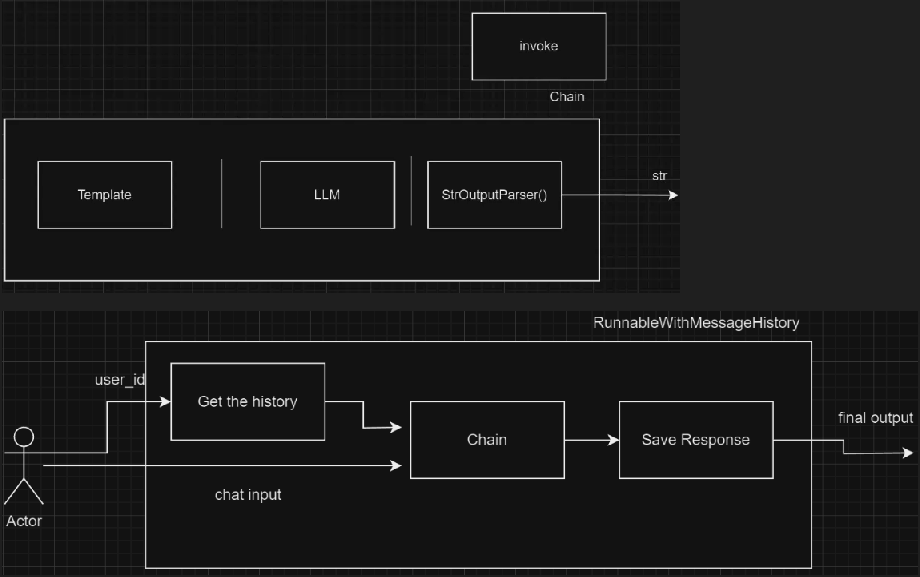

#### Simplified pseudo-flow of what happens internally for the combination ChatMessageHistory with get_session_history 
<pre>
user_input = "Hello!"                 ##### User sends a message
history = get_session_history(session_id) ##### Retrieve or create session history
history.add_user_message(user_input)  ##### Add user input to the history
model_response = model(user_input)    ##### Generate model response
history.add_ai_message(model_response) ##### Add model response to the history
return model_response                 ##### Return the response
</pre>

<div style="width: 80%; margin: 0 auto; font-size: 16px; line-height: 1.6;">
    When a user sends a message (like "Hello!"), the system checks if there's an existing chat history for the given session ID by looking it up in the <code>store</code> dictionary. If no history exists, it creates a new one and saves it in the <code>store</code> under that session ID. The user's message is then added to the chat history. Next, the system uses the model to generate a response based on the user's input. This response is also added to the chat history. Finally, the model's response is returned to the user. This way, all messages (both user inputs and model responses) are saved in the <code>store</code> dictionary, organized by session ID, ensuring the conversation history is preserved for each session.
</div>


In [3]:
##Sessions based chat history 
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable
groq_api_key=os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
model=ChatGroq(model="Gemma2-9b-It",groq_api_key=groq_api_key)

# to store the conversation history, we use a dictionary where the session id is the key and the ChatMessageHistory is the value.
store={}
def get_session_history(session_id:str)->BaseChatMessageHistory:
    if session_id not in store:
        store[session_id]=ChatMessageHistory()
    return store[session_id]

with_message_history=RunnableWithMessageHistory(model,get_session_history) # makes the language model (model) runnable with message history. 
config={"configurable":{"session_id":"chat1"}} 
response=with_message_history.invoke(
    [HumanMessage(content="Hi , My name is DP Sharma and I am a Chief AI Engineer")],
    config=config
)
print("First response-output with chat1====================>",response.content)
response=with_message_history.invoke(
    [HumanMessage(content="What's my name?")],
    config=config,
)
print("Second response-output with chat1====================>",response.content)
config1={"configurable":{"session_id":"chat2"}} 
response=with_message_history.invoke(
    [HumanMessage(content="What's my name?")],
    config=config1
)
print("Response-output with New Session-chat2===============>",response.content)

First response-output with chat1====================> Hello DP Sharma! It's nice to meet you.  

Being a Chief AI Engineer is a very exciting role. What kind of projects are you working on these days?  I'm always interested in learning more about how AI is being used in different industries.

Second response-output with chat1====================> Your name is DP Sharma.  

As a large language model, I have access to the information you provided in our conversation. I remember that you introduced yourself as DP Sharma, Chief AI Engineer.  😊

Response-output with New Session-chat2===============> As an AI, I have no memory of past conversations and do not know your name. If you'd like to tell me your name, I'd be happy to know! 😊



#### Difference Between Static and Dynamic Prompt (With Reference to chat-Meassage History)
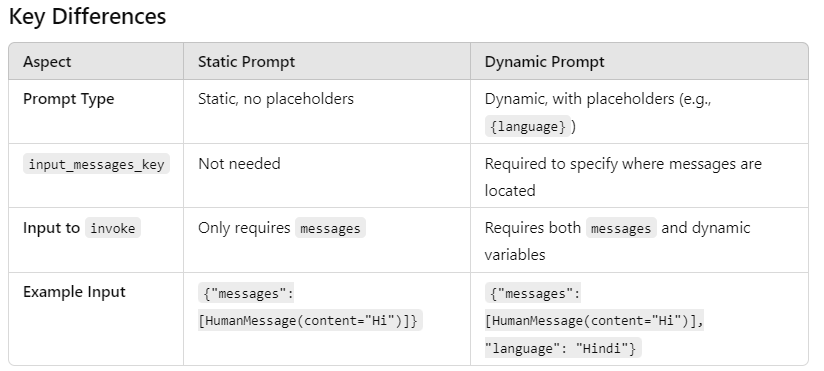

#### Static Prompt Template 
##### Prompt Templates
- Prompt Templates help to turn raw user information into a format that the LLM can work with. In this case, the raw user input is just a message, which we are passing to the LLM. Let's now make that a bit more complicated. First, let's add a system message with some custom instructions (while still taking messages as input). Next, we'll add more input besides just the messages.
- In the below code, the **MessagesPlaceholder** acts as a placeholder for a sequence of messages (not just human messages, but potentially a mix of user and assistant messages) that will be dynamically provided during runtime.</br>
-Example:  
```python
messages = [
    {"system","You are a helpful assistant.Amnswer all the question to the nest of your ability"}
    {"user": "Tell me a joke."},
    {"assistant": "Why did the scarecrow win an award? Because he was outstanding in his field!"}
]
chain.invoke({"messages": messages})

In [4]:
## Static Prompt Template 
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
# Load environment variables
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
# Initialize model
model = ChatGroq(model="Gemma2-9b-It", groq_api_key=groq_api_key)
# Store for session histories
store = {}
# Function to get or create session history
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
       store[session_id] = ChatMessageHistory()
    return store[session_id]
# Static system prompt
prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are a helpful assistant.Amnswer all the question to the nest of your ability"),
        MessagesPlaceholder(variable_name="messages")
    ]
)
chain=prompt|model
with_message_history=RunnableWithMessageHistory(chain,get_session_history)
config = {"configurable": {"session_id": "chat3"}}
response=with_message_history.invoke(
    [HumanMessage(content="Hi My name is DPSharma")],
    config=config
)
print("First response-output with chat3====================>",response.content) 

response=with_message_history.invoke({"messages":[HumanMessage(content="What is my name")]},config=config)
print("First response-output with chat3====================>",response.content)

First response-output with chat3====================> Hello DPSharma, it's nice to meet you!

I'm happy to help answer your questions to the best of my ability.  

What can I do for you today? 😊  


First response-output with chat3====================> Your name is DPSharma.  I remember!  😊 

Is there anything else I can help you with? 






##### Dynamic Prompt Template

In [5]:
## Dynamic Prompt Template
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
# Load environment variables
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
# Initialize model
model = ChatGroq(model="Gemma2-9b-It", groq_api_key=groq_api_key)
# Store for session histories
store = {}
# Function to get or create session history
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]
# Define prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
# Define chain and message history wrapper
chain = prompt | model
with_message_history = RunnableWithMessageHistory(chain,get_session_history,input_messages_key="messages")
# Test first session
config = {"configurable": {"session_id": "chat4"}}
response = with_message_history.invoke(
    {"messages": [HumanMessage(content="Hi, I am DPSharma, save my name.")], "language": "Hindi"},
    config=config,
)
print("First response-output with chat4====================>",response.content)

# Second interaction for the same session (history should update automatically)
response = with_message_history.invoke(
    {"messages": [HumanMessage(content="What's my name?")], "language": "Hindi"},
    config=config,
)
print("First response-output with chat4====================>",response.content)

# Test a different session
config = {"configurable": {"session_id": "chat5"}}
response = with_message_history.invoke(
    {"messages": [HumanMessage(content="What's my name?")], "language": "Hindi"},
    config=config,
)
print("First response-output with chat5====================>",response.content)



First response-output with chat4====================> नमस्ते DPSharma, 

मुझे ख़ुशी है आपसे मिलने का। आपका नाम अब मुझे याद है। 

आप मुझसे कोई भी सवाल पूछ सकते हैं, मैं अपनी पूरी कोशिश करूँगा कि आपको मदद करूँ। 😊


First response-output with chat4====================> आपका नाम DPSharma है।  😊 

First response-output with chat5====================> मैं एक मददगार सहायक हूँ, लेकिन मुझे आपका नाम नहीं पता।  क्या आप मुझे बताना चाहेंगे? 😊 



### Managing the Conversation History
- When building chatbots, it’s important to manage the list of messages exchanged between the user and the system. If this list becomes too long, it can cause problems because the language model has a limit on how much information it can handle at once.
- 'trim_messages' helper to reduce how many messages we're sending to the model. The trimmer allows us to specify how many tokens we want to keep, along with other parameters like if we want to always keep the system message and whether to allow partial messages.

### Breakdown of Arguments Passed to `trim_messages`

- **`max_tokens=45`**
  - Specifies the maximum number of tokens (units of text) allowed in the trimmed conversation.
  - Ensures that the total size of the messages sent to the model stays within this limit.

- **`strategy="last"`**
  - Determines which messages to prioritize when trimming.
  - The "last" strategy means the most recent messages are kept, and older ones are removed first.

- **`token_counter=model`**
  - Specifies how tokens are counted.
  - The model is used to measure the number of tokens in each message, ensuring accurate token limits.

- **`include_system=True`**
  - Ensures the system message (e.g., instructions or role setup) is always included, even when trimming.
  - Useful for keeping context about the chatbot’s role.

- **`allow_partial=False`**
  - Disables partial trimming of individual messages.
  - If a message cannot fit within the token limit, it will be removed entirely rather than being shortened.

- **`start_on="human"`**
  - Specifies where trimming starts in the sequence of messages.
  - In this case, trimming begins with the first message from a human user and works backward (or forward, depending on the strategy).

### How `invoke` Works
The `invoke` method applies these rules to the provided list of messages. It ensures:
- The total tokens fit within the specified `max_tokens` limit.
- The trimming follows the defined strategy, starting point, and constraints.


In [6]:
from langchain_core.messages import SystemMessage,trim_messages
trimmer=trim_messages(
    max_tokens=45,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human"
)
messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]
trimmer.invoke(messages)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

d:\LeonBasics\Lvenv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\devi.psharma\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

d:\LeonBasics\Lvenv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]